In [17]:
import pandas as pd

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sb

import pycountry_convert as pc  # 나라이름 => 대륙
from sklearn.linear_model import LinearRegression # 선형회귀


## 개요
 [Suicide Rates Overview 1985 to 2016](<https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016>), kaggle
 
* 1985년부터 2016년까지 국가, 연도, 나이구간에 따른 자살인원 수, 자살률 데이터 27,820건
* 열 : 12개

* 데이터 상세
    * 명목형
        * country : 101개 국가
        * year : 연도, 1985-2016
        * sex : 성별, male/femail
        * age  : 나이그룹,  5-14, 15-24, 25-34, 35-54, 55-74, 75+
        * country-year composite key : 국가-연도    
        *  generation : 세대별 출생 연도
            * GI Generation: 1900-1920
            * Silent: 1925-1945
            * Boomers: 1955-1964
            * Generation X : 1965-1979
            * Millenials: 1980-1994
            * Generation Z: 1995-2015
    * 수치형
        * count of suicides: 해당년도 자살자 수
        * population: 인구
        * suicide rate: 10만명당 자살자 수
        * [HDI for year](<https://ko.wikipedia.org/wiki/%EC%9D%B8%EA%B0%84_%EA%B0%9C%EB%B0%9C_%EC%A7%80%EC%88%98>) : 인간 개발 지수, Human Developement Index
        * gdp_for_year : 연간 GDP
        *  gdp_per_capita : 일인당 GPD
    
    
* References
  * [[R] Suicide Rates (in-depth) - Stats & Insights](<https://www.kaggle.com/lmorgan95/r-suicide-rates-in-depth-stats-insights>)

## 주요 인사이트
* 세계적으로 자살율은 감소하는 추세다
* 연도에 따른 자살율 추이가 선형성을 띄는 국가중 2/3은 자살율이 감소하고 있다.
* 평균적으로 나이가 많을 수록 자살율이 증가한다.
    * 아메리카, 아시아, 유럽 대륙에서는 나이가 많을수록 자살율이 증가한다.
    * 아프리카와 오세아니아 대륙에서는 적용되지 않는다.
* 인당GDP와 자살율은 약한 양의 상관관계가 있다.
* 자살율의 최댓값은 225다(인구 10만명 당 자살자 수)
* 남성의 자살율이 상대적으로 과장됐다.

In [2]:
## Load & Check data
data_route = r'D:\document\data\Suicied_rate_overview_kaggle\master.csv'
df_raw = pd.read_csv(data_route)
df_raw.describe(include='all')

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
count,27820,27820.000000,27820,27820,27820.000000,2.782000e+04,27820.000000,27820,8364.000000,27820,27820.000000,27820
unique,101,NaN,2,6,NaN,NaN,NaN,2321,NaN,2321,NaN,6
top,Iceland,NaN,male,25-34 years,NaN,NaN,NaN,Canada1996,NaN,"4,732,017,873",NaN,Generation X
freq,382,NaN,13910,4642,NaN,NaN,NaN,12,NaN,12,NaN,6408
mean,NaN,2001.258375,NaN,NaN,242.574407,1.844794e+06,12.816097,NaN,0.776601,NaN,16866.464414,NaN
std,NaN,8.469055,NaN,NaN,902.047917,3.911779e+06,18.961511,NaN,0.093367,NaN,18887.576472,NaN
min,NaN,1985.000000,NaN,NaN,0.000000,2.780000e+02,0.000000,NaN,0.483000,NaN,251.000000,NaN
25%,NaN,1995.000000,NaN,NaN,3.000000,9.749850e+04,0.920000,NaN,0.713000,NaN,3447.000000,NaN
50%,NaN,2002.000000,NaN,NaN,25.000000,4.301500e+05,5.990000,NaN,0.779000,NaN,9372.000000,NaN
75%,NaN,2008.000000,NaN,NaN,131.000000,1.486143e+06,16.620000,NaN,0.855000,NaN,24874.000000,NaN


## 데이터 클리닝
* 데이터 수가 3개년 이하인 국가는 삭제
    * Cabo Verde                 1
    * Mongolia                   1
    * Macau                      1
    * Dominica                   1
    * Bosnia and Herzegovina     2
    * Saint Kitts and Nevis      3
    * San Marino                 3
    * Oman                       3
* HDI 열의 70%가 결측치 이므로 삭제한다.
* 대륙(continent) 변수 추가

* 커널에는 있으나 적용하지 않은 요인
    * Generation variable has problems, detailed in 2.11
    * Africa has very few countries providing suicide data
    * 2016 data was removed (few countries had any, those that did often had data missing)

In [3]:
display(df_raw.isnull().mean())  # 열별 결측치 비율확인
df_clean = df_raw.copy(deep=True)  # cleaned data frame
df_clean.drop(columns=['HDI for year'], inplace=True) # HDI 제거

country               0.000000
year                  0.000000
sex                   0.000000
age                   0.000000
suicides_no           0.000000
population            0.000000
suicides/100k pop     0.000000
country-year          0.000000
HDI for year          0.699353
 gdp_for_year ($)     0.000000
gdp_per_capita ($)    0.000000
generation            0.000000
dtype: float64

In [4]:
# 나라별 몇개년 데이터가 있는가?
year_count = df_raw.groupby(['country'])['year'].nunique().sort_values()
display(year_count[:8])
# 데이터가 3개년 이하인 나라는 제거한다.
country_under_3_year = year_count[year_count<=3].index 
df_clean = df_clean[df_clean['country'].apply(lambda country: False if country in  country_under_3_year else True)]

country
Cabo Verde                1
Mongolia                  1
Macau                     1
Dominica                  1
Bosnia and Herzegovina    2
Saint Kitts and Nevis     3
San Marino                3
Oman                      3
Name: year, dtype: int64

In [5]:
# 대륙변수 추가
df_clean['country'] = df_clean['country'].apply(lambda x: 'Saint Vincent and the Grenadines' if x=='Saint Vincent and Grenadines' else x)
df_clean['country'] = df_clean['country'].apply(lambda x: 'South Korea' if x=='Republic of Korea' else x)

def country2continet(country):
    country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
    continent_name = pc.country_alpha2_to_continent_code(country_code)
    return continent_name

df_clean['continent'] = df_clean['country'].apply(country2continet)

In [6]:
df_clean['continent'].value_counts()

EU    11358
NA     6010
AS     5308
SA     3156
OC      972
AF      838
Name: continent, dtype: int64

## 전세계 트렌드 분석

### 전세계 연도별 자살율

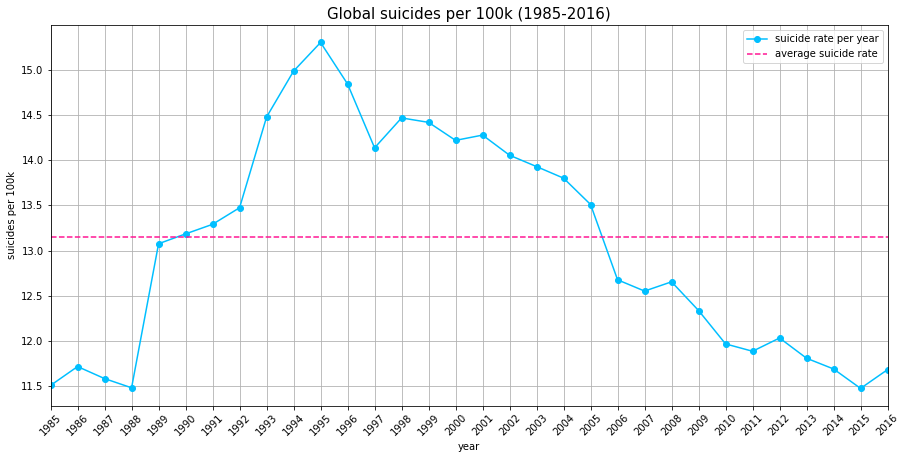

In [7]:
# 연도별 인구 10만명당 자살자 수
pop_year = df_clean.groupby(['year'])['population'].sum()
suic_year = df_clean.groupby(['year'])['suicides_no'].sum()

suic_rate_year = (suic_year/pop_year)*100000
suic_avg = (suic_year.sum()/pop_year.sum())*100000

plt.figure(figsize=(15,7))
suic_rate_year.plot(marker='o', label='suicide rate per year', grid=True,color='deepskyblue')
plt.axhline(suic_avg, ls='--', label='average suicide rate', color='deeppink')
plt.title('Global suicides per 100k (1985-2016)', fontsize=15)
plt.ylabel('suicides per 100k')
plt.xticks(suic_rate_year.index, rotation=45)
plt.legend()
plt.show()

* 자살율 최댓값은 15.3(명/10만명)으로 **1995**년에 발생했다.
* **1995년부터 2015년**까지 자살율이 계속 감소했다. 2015년 자살율은 11.47(명/10만명)이다.
* **2016년** 자살율은 11.68(명/10만명)으로 전년에 비해 소폭(0.21p(명/10만명)) 상승했다.
* **1988년에서 1989년** 사이에 자살율이 급증했다.

### 대륙별 자살율

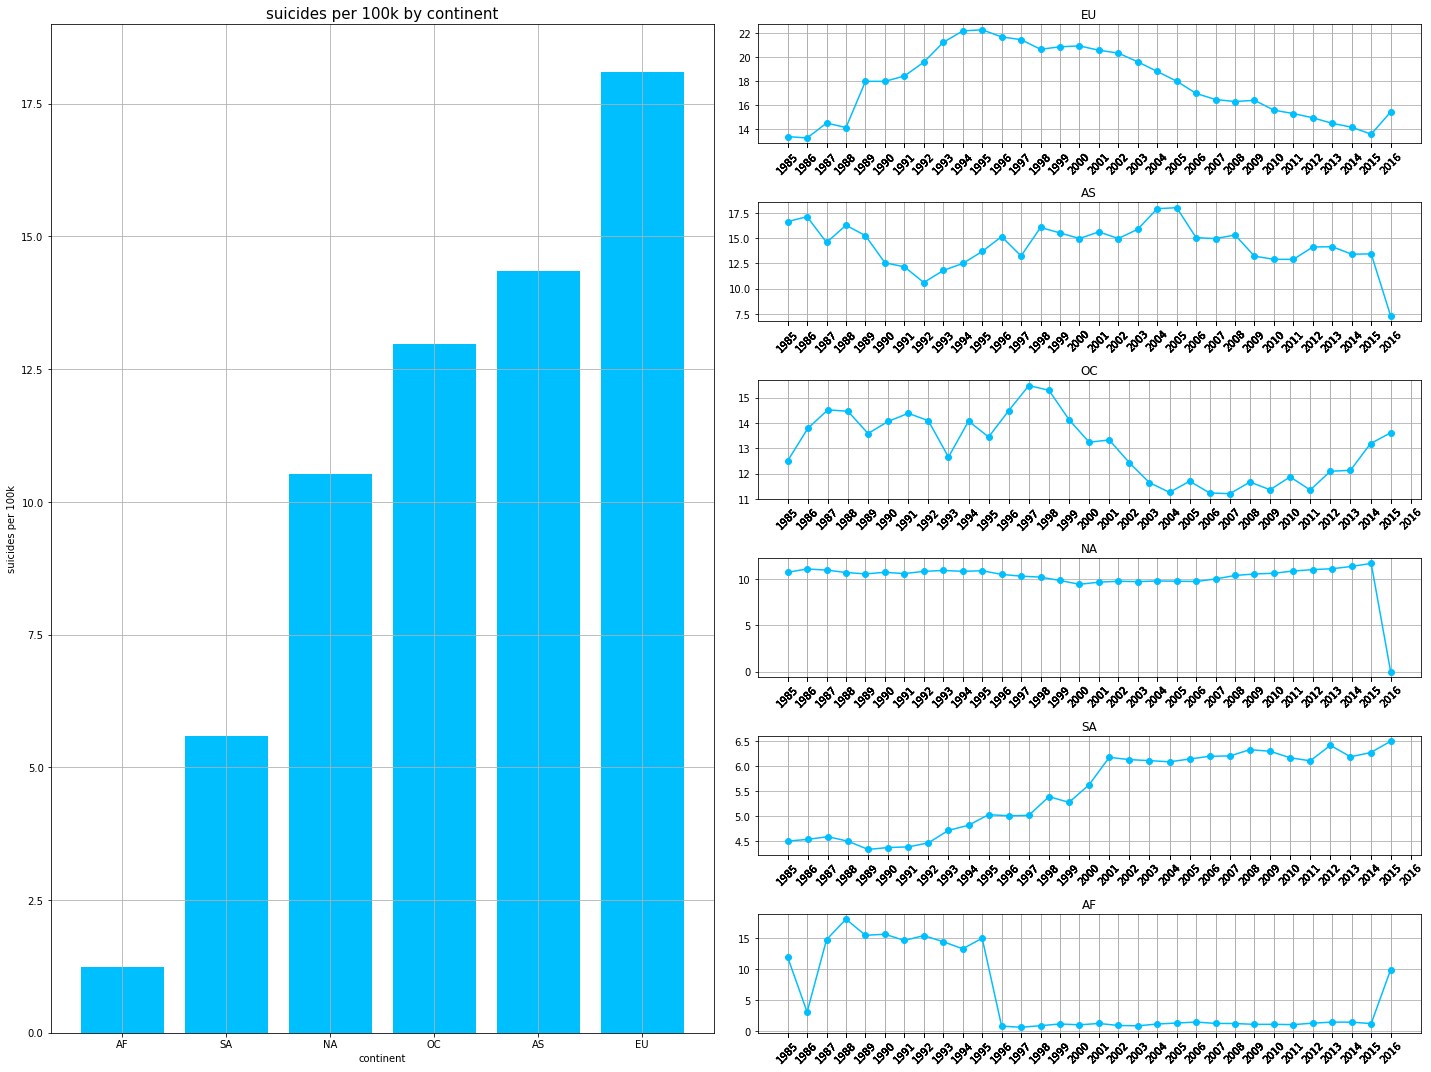

In [8]:
plt.figure(figsize=(20,15))
gs = gridspec.GridSpec(6, 2)

ax = plt.subplot(gs[:,0])
pop_continent = df_clean.groupby(['continent'])['population'].sum()
suic_continent = df_clean.groupby(['continent'])['suicides_no'].sum()
suic_rate_continent = (suic_continent/pop_continent)*100000
suic_rate_continent = suic_rate_continent.sort_values()
ax.bar(x=suic_rate_continent.index, height=suic_rate_continent, color='deepskyblue')
ax.set_title('suicides per 100k by continent', fontsize=15)
ax.set_ylabel('suicides per 100k')
ax.set_xlabel('continent')
ax.grid()

pop_cont_year = df_clean.groupby(['continent', 'year'])['population'].sum()
suic_cont_year =  df_clean.groupby(['continent', 'year'])['suicides_no'].sum()
suic_rate_cont_year = ((suic_cont_year/pop_cont_year)*100000).reset_index()
continents = ['EU', 'AS', 'OC', 'NA', 'SA', 'AF']

ax_sub = [
    plt.subplot(gs[0,1]),
    plt.subplot(gs[1,1]),
    plt.subplot(gs[2,1]),
    plt.subplot(gs[3,1]),
    plt.subplot(gs[4,1]),
    plt.subplot(gs[5,1])
]

for i in range(6):
    tmp = suic_rate_cont_year[suic_rate_cont_year['continent']==continents[i]]
    ax_sub[i].plot(tmp['year'], tmp[0], marker='o', color='deepskyblue')
    ax_sub[i].set_xticks(suic_rate_cont_year['year'])
    ax_sub[i].set_xticklabels(suic_rate_cont_year['year'], rotation=45)
    ax_sub[i].set_title(continents[i])
    ax_sub[i].grid()
plt.tight_layout()
plt.show()

* 유럽의 자살율이 가장 높다. 유럽의 자살율은 1995년 부터 점차 감소한다.
* 아시아의 자살율은 2005년 이후로 감소하는 추세다. 2016년 데이터는 'Armenia', 'Cyprus', 'Qatar', 'Thailand' 4개 국가밖에 없다.
* 오세아니아의 자살율은 1997년에 최댓값을 기록하고, 이후 하락하는 추세다.
* 북아메리카의 자살율은 2015년까지 거의 일정한 추세다. 북아메리카-2016년 데이터는 'Grenada'만 존재한다.
* 남아메리카의 자살율은 계속 증가하는 추세다.
* 아프리카 대륙의 자살율 추세는 데이터가 부족해 잘 드러나지 않았다. 아프리카 대륙의 국가는 'Mauritius', 'Seychelles', 'South Africa' 3개 국가 밖에 없다.


### 성별별 자살율

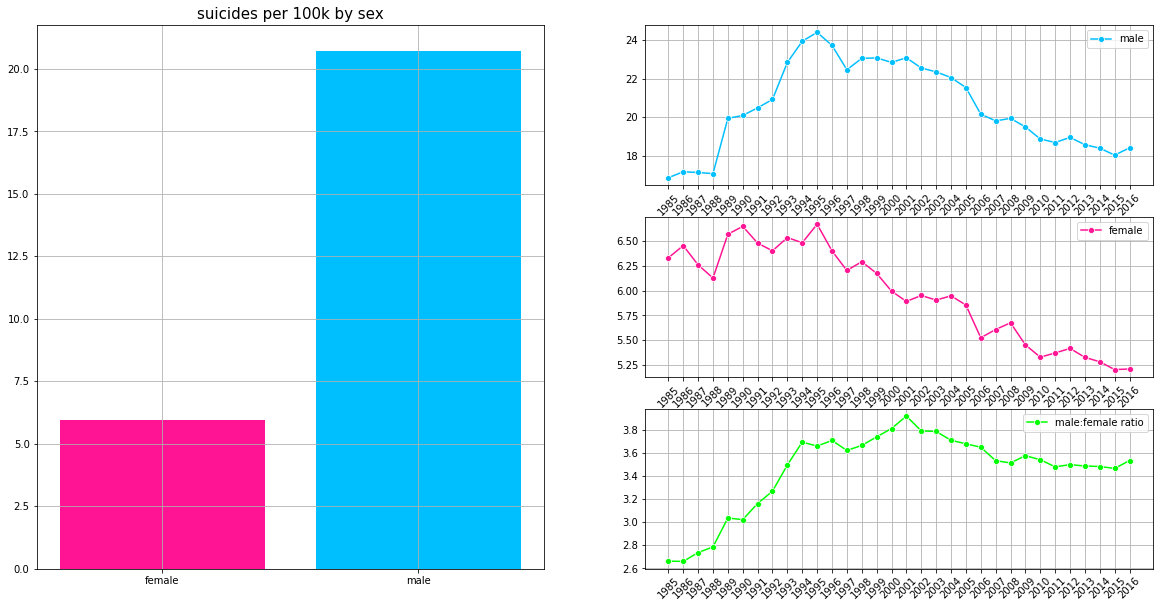

In [9]:
pop_sex = df_clean.groupby(['sex'])['population'].sum()
suic_sex = df_clean.groupby(['sex'])['suicides_no'].sum()
suic_rate_sex = (suic_sex/pop_sex)*100000

plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(3,2)
ax = plt.subplot(gs[:,0])
ax.bar(x=suic_rate_sex.index, height=suic_rate_sex, color=['deeppink', 'deepskyblue'])
ax.grid()
ax.set_title('suicides per 100k by sex', fontsize=15)

pop_sex_year = df_clean.groupby(['sex', 'year'])['population'].sum()
suic_sex_year = df_clean.groupby(['sex', 'year'])['suicides_no'].sum()
suic_rate_sex_year = ((suic_sex_year/pop_sex_year)*100000).reset_index()

ax_time = [plt.subplot(gs[0,1]), plt.subplot(gs[1,1])]
sex = ['male', 'female']
color=['deepskyblue','deeppink']

for i in range(2):
    tmp = suic_rate_sex_year[suic_rate_sex_year['sex']==sex[i]]
    sb.lineplot(x=tmp['year'], y=tmp[0], marker='o', color=color[i], ax=ax_time[i], label=sex[i])
    ax_time[i].grid()
    ax_time[i].set_xticks(tmp['year'])
    ax_time[i].set_xticklabels(tmp['year'], rotation=45)
    ax_time[i].set_ylabel('')
    ax_time[i].set_xlabel('')

# 남여 연도별 자살율 비율
tmp_male = suic_rate_sex_year[suic_rate_sex_year['sex']=='male']
tmp_female = suic_rate_sex_year[suic_rate_sex_year['sex']=='female']
male_female_ratio = tmp_male[0].values/tmp_female[0].values
ax3 = plt.subplot(gs[2,1])
sb.lineplot(x=tmp_male['year'], y=male_female_ratio, marker='o', color='lime', ax=ax3, label='male:female ratio')
ax3.grid()
ax3.set_xticks(tmp_male['year'])
ax3.set_xticklabels(tmp_male['year'], rotation=45)
ax3.set_ylabel('')
ax3.set_xlabel('')
plt.show()

* 자살율은 남성이 약 3.5배가량 높다.
* 남여 모두 1995년에 자살율이 최대며 이후 점차 감소하는 추세다.
* 90년대 이후 남성과 여성의 자살율 비는 3.5-4 를 유지한다.
* 80년대 남성과 여성의 자살율 비는 2.6-2.8 정도다.

### 연령별 자살율

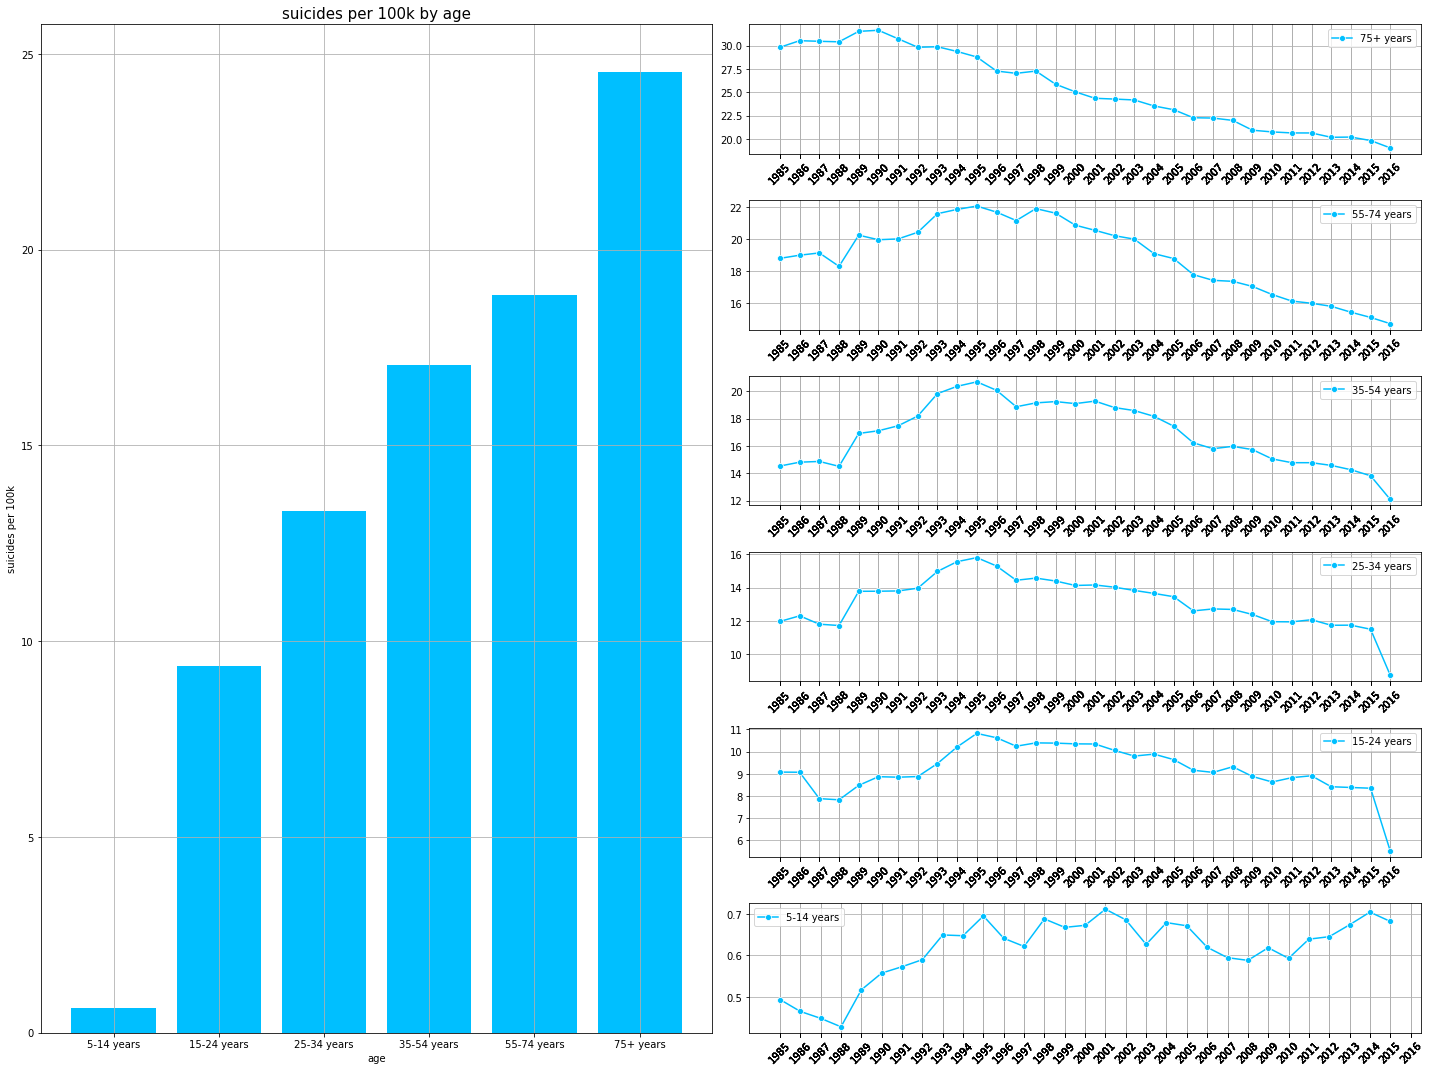

In [10]:
plt.figure(figsize=(20,15))
gs = gridspec.GridSpec(6, 2)

ax = plt.subplot(gs[:,0])
pop_age = df_clean.groupby(['age'])['population'].sum()
suic_age = df_clean.groupby(['age'])['suicides_no'].sum()
suic_rate_age = (suic_age/pop_age)*100000
suic_rate_age = suic_rate_age.sort_values()
ax.bar(x=suic_rate_age.index, height=suic_rate_age, color='deepskyblue')
ax.set_title('suicides per 100k by age', fontsize=15)
ax.set_ylabel('suicides per 100k')
ax.set_xlabel('age')
ax.grid()

pop_age_year = df_clean.groupby(['age', 'year'])['population'].sum()
suic_age_year =  df_clean.groupby(['age', 'year'])['suicides_no'].sum()
suic_rate_age_year = ((suic_age_year/pop_age_year)*100000).reset_index()
age = ['75+ years', '55-74 years', '35-54 years', '25-34 years', '15-24 years', '5-14 years']

ax_sub = [
    plt.subplot(gs[0,1]),
    plt.subplot(gs[1,1]),
    plt.subplot(gs[2,1]),
    plt.subplot(gs[3,1]),
    plt.subplot(gs[4,1]),
    plt.subplot(gs[5,1])
]

for i in range(6):
    tmp = suic_rate_age_year[suic_rate_age_year['age']==age[i]]
    sb.lineplot(tmp['year'], tmp[0], marker='o', color='deepskyblue', ax=ax_sub[i], label=age[i])
    ax_sub[i].set_xticks(suic_rate_age_year['year'])
    ax_sub[i].set_xticklabels(suic_rate_age_year['year'], rotation=45)
    ax_sub[i].set_xlabel('')
    ax_sub[i].set_ylabel('')
    ax_sub[i].grid()
plt.tight_layout()
plt.show()

* 전반적으로 자살율은 감소하는 추세다
* 5-14세 구간을 제외한 모든 나이대에서 1995년 이후 자살율이 선형적으로 감소한다.
* 75+, 55-74 세 구간에서 1990년대 이후로 50p% 이상 자살율이 감소했다.
* 5-14세 구간의 자살율은 모든 연도에서 1(명/10만명) 이하다.

### 국가별 경향

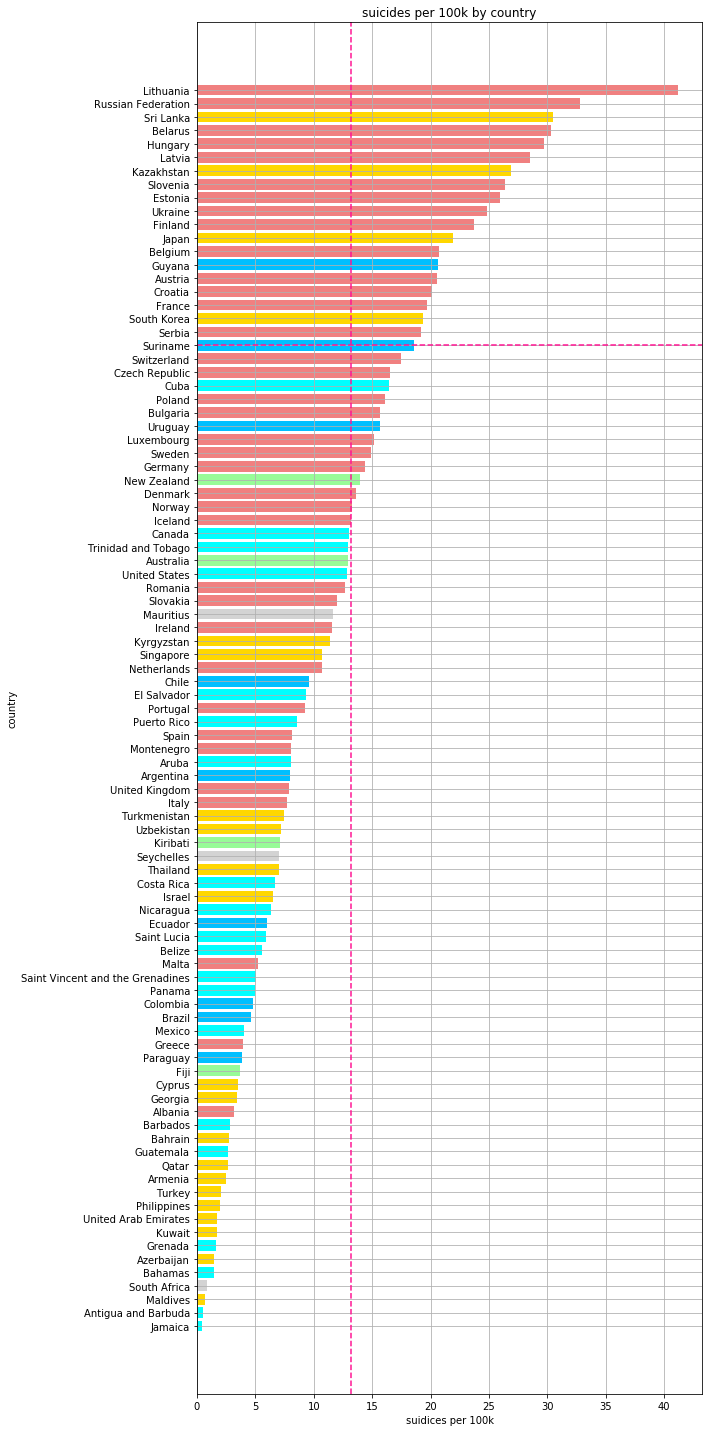

In [13]:
pop_country = df_clean.groupby(['country', 'continent'])['population'].sum()
suic_country = df_clean.groupby(['country', 'continent'])['suicides_no'].sum()
avg_suic_rate = (suic_country.sum()/pop_country.sum())*100000
suic_rate_country = ((suic_country/pop_country)*100000).reset_index().sort_values(by=0, ascending=True)
suic_rate_country.rename(columns={0: 'suicides rate'}, inplace=True)

# color
color_dict = {
    'EU':'lightcoral',
    'NA':'aqua',
    'SA':'deepskyblue',
    'AS':'gold',
    'AF':'lightgrey',
    'OC':'palegreen'
             }
suic_rate_country['color'] = suic_rate_country['continent'].apply(lambda continent: color_dict[continent])

plt.figure(figsize=(10,20))
# sb.barplot(y='suicides rate', y='country', data=suic_rate_country, hue='continent')
plt.barh(width='suicides rate', y='country', data=suic_rate_country, color='color')
plt.axvline(avg_suic_rate, color='deeppink', ls='--')
n_coutries = suic_rate_country['country'].nunique()
plt.axhline(n_coutries-20, color='deeppink', ls='--')  # top 20 line

plt.xlabel('suidices per 100k')
plt.ylabel('country')
plt.title('suicides per 100k by country')
plt.grid()
plt.tight_layout()
plt.show()

* 리투아니아의 자살율이 가장 높다(40 이상)
* 자살율 상위 20개 국가 중 14개 국가가 유럽이다(전체 국가 수: 93). 아시아 국가는 스리랑카, 카자흐스탄, 일본, 한국이 있다.
* 스리랑카는 아시아 국가중 자살율이 가장 높으며, 세계 3위다.
* 대부분 아메리카 대륙 국가는 중하위권에 속해있는데 반해 가이아나(GUYANA)가 13위를 기록했다.

---

* 대륙별 나라의 수가 일정하지 않다. 유럽은 36개 국가의 정보가 있는데 반해 아프리카는 3개 국가 밖에 없다. 데이터가 부족하기에 아프리카의 자살율이 과소평가됐을 수도 있다. 또한 대륙별 국가당 연도 데이터 수 분포도 유럽이 전반적으로 가장 높은 것으로 보인다.

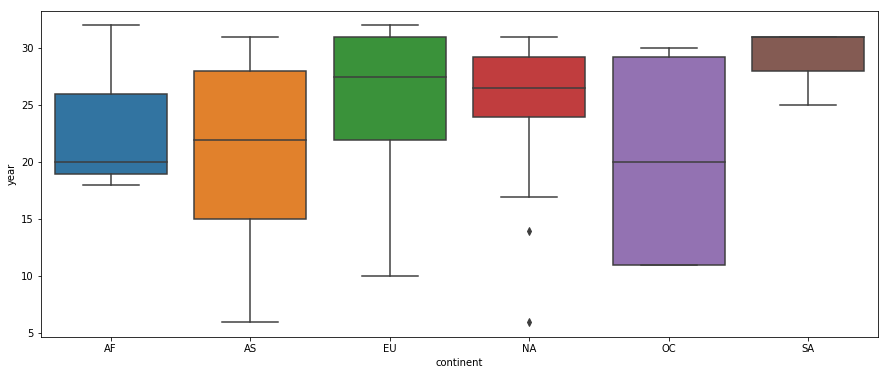

In [18]:
# 대륙별 국가당 연도 데이터 수 분포
plt.figure(figsize=(15, 6))
tmp = df_clean.groupby(['continent','country'])['year'].nunique().reset_index()
sb.boxplot(x='continent', y='year', data=tmp)
plt.show()

* 전반적으로 대륙별/ 나라별 자살율이 크게 차이나기 때문에 대륙별/ 나라별 자살율을 비교하는 것은 유의미하지 않다. 다만 국가 내 연간 자살율 추이를 비교하는 것은 가능하다.

#### 국가별 연도에 따른 자살율 선형성 확인
* 시간이 흐를수록 자살율이 꾸준히 증가/감소 하는가?
* 선형회귀하고 RMSE, R square, P Value를 비교한다.

In [19]:
pop = df_clean.groupby(['country','year'])['population'].sum().reset_index()
suic = df_clean.groupby(['country','year'])['suicides_no'].sum().reset_index()
tmp = (suic['suicides_no']/pop['population']) * 10000
suic_rate = pop.copy(deep=True)
suic_rate.drop(columns=['population'], inplace=True)
suic_rate['suicides_rate'] = tmp

In [21]:
# 나라별로 선형회귀를 진행
# r square > 0.6 이상인 나라만 선별
country_selected = []
for country in suic_rate['country'].unique():
    x = suic_rate[suic_rate['country']==country]['year'].values.reshape(-1 , 1)
    y = suic_rate[suic_rate['country']==country]['suicides_rate'].values.reshape(-1, 1)
    reg = LinearRegression().fit(x, y)
    if reg.score(x, y) > 0.6:
        country_selected.append([country, reg.coef_[0][0]])

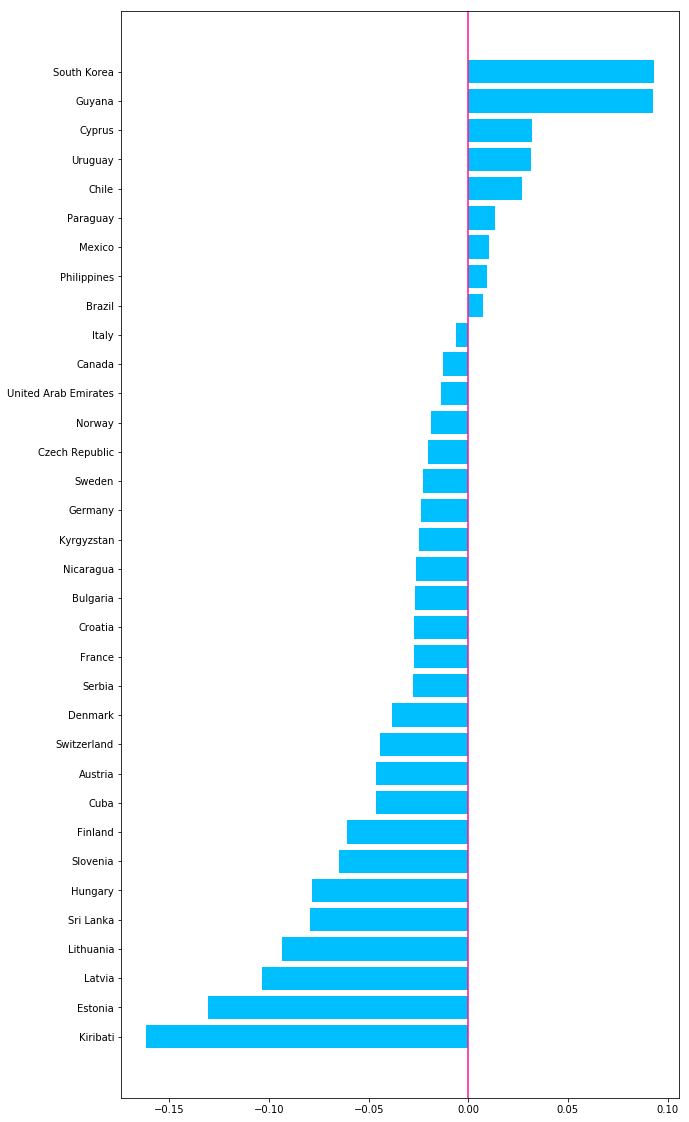

In [67]:
plt.figure(figsize=(10,20))
suic_rate_slope = pd.DataFrame(country_selected).rename(columns = {0: 'country', 1:'slope'})
suic_rate_slope = suic_rate_slope.sort_values(by='slope')
plt.barh(width='slope', y='country', data=suic_rate_slope, color='deepskyblue')
plt.axvline(0, color='deeppink')
plt.show()

* 한국, 가이아나 가 자살율 상승세가 제일 크다.
* 에스토니아, 키리바시는 자살율 하락세가 제일 크다.

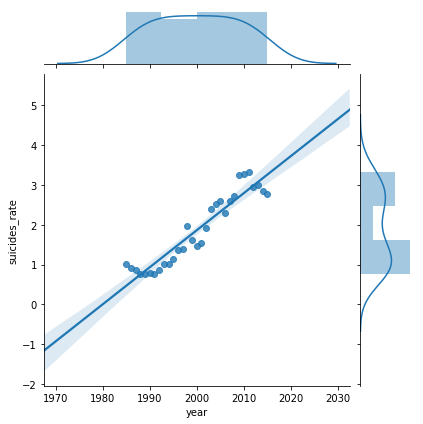

In [24]:
# 한국의 자살율
sb.jointplot(suic_rate[suic_rate['country'] == 'South Korea']['year'], 
        suic_rate[suic_rate['country'] == 'South Korea']['suicides_rate'],
        kind="reg")
plt.show()

### 대륙에 따른 성별 분포

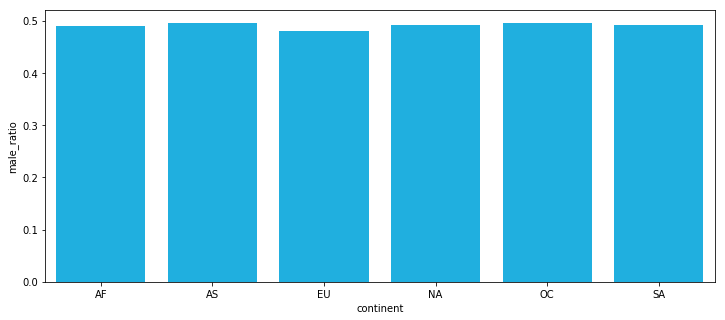

In [60]:
population_by_continent = df_clean.groupby(['continent'])['population'].sum().reset_index()
population_male_by_continent= df_clean[df_clean['sex']=='male'].groupby(['continent'])['population'].sum().reset_index()
population_by_continent['male_ratio'] = population_male_by_continent['population']/population_by_continent['population']

plt.figure(figsize=(12,5))
sb.barplot(x='continent', y='male_ratio', data=population_by_continent, color='deepskyblue')
plt.show()

* 성비는 모든 대륙에 걸쳐 0.5이하로 비슷하다.

### 국가에 따른 성별 분포

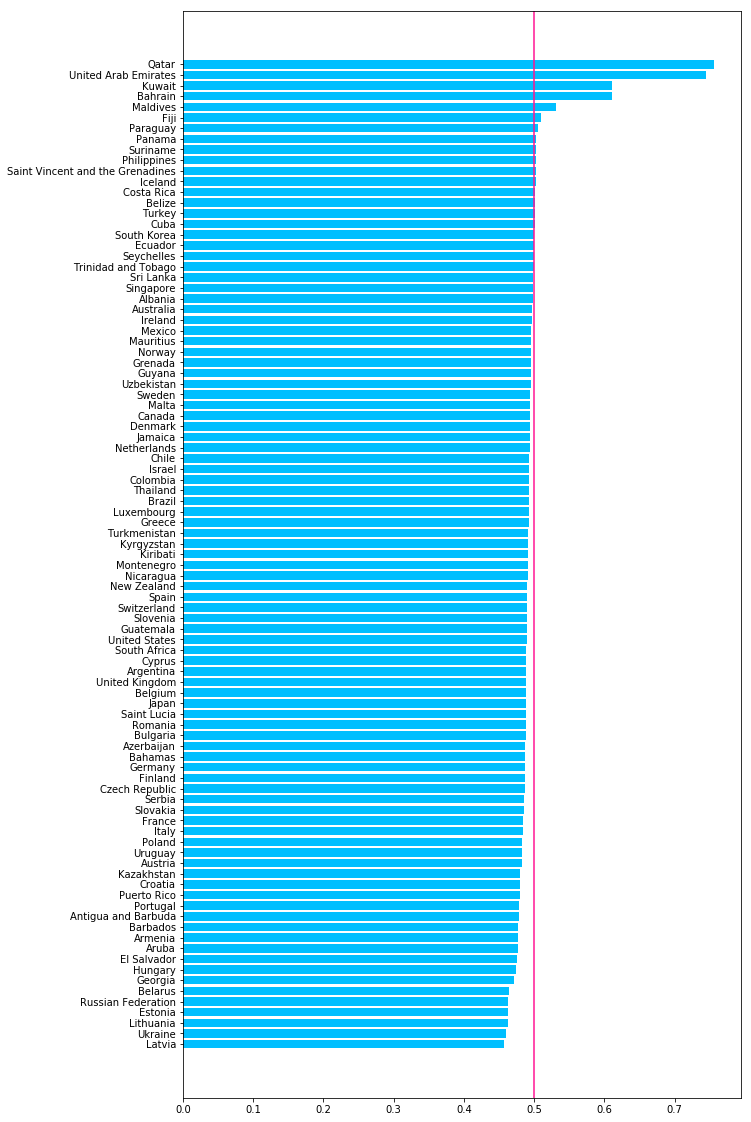

In [66]:
population_by_country = df_clean.groupby(['country'])['population'].sum().reset_index()
population_male_by_country = df_clean[df_clean['sex']=='male'].groupby(['country'])['population'].sum().reset_index()
population_by_country['male_ratio'] = population_male_by_country['population']/population_by_country['population']
population_by_country = population_by_country.sort_values(by='male_ratio')

plt.figure(figsize=(10,20))

plt.barh(width='male_ratio', y='country', data=population_by_country, color='deepskyblue')
plt.axvline(x=0.5, color='deeppink')
plt.show()

### 대륙에 따른 나이대 분포

### 나라가 부유할수록 자살율이 낮은가?

### 부유한 나라가 자살 위험이 높은가?

### 세대 변수를 사용하지 않은 이유

### The 5% highest risk instance in history

### 영국, 아일랜드, 미국, 프랑스, 덴마크 비교

#### 개요

#### 성별에 따른 차이

#### 2010-2015년

#### 나이대별

##### 남자 : 15-54세

##### 남자 : 15-24, 25-34, 35-54 세